## Environment: Reacher (MuJoCo)

This environment features a 2-joint robotic arm. The agent’s goal is to control the joint torques so that the arm's **fingertip reaches a randomly placed target** in a 2D space.

#### Observation Space (`Box(-inf, inf, shape=(10,))`):
Each observation is a 10-dimensional continuous vector composed of:

- **$\cos(\theta_1), \cos(\theta_2)$**: Cosines of the two joint angles
- **$\sin(\theta_1), \sin(\theta_2)$**: Sines of the two joint angles
- **$target\_x, target\_y$**: 2D coordinates of the target position
- **$q\_vel_1, q\_vel_2$**: Angular velocities of joints 1 and 2
- **$x_{diff}, y_{diff}$**: Vector from fingertip to target position

####  Action Space (`Box([-1, -1], [1, 1])`, shape=(2,)):
The action is a 2D torque vector:

- **$a = [a_1, a_2]$**, where $a_1$ and $a_2$ are torques applied to the two joints.
- Values are continuous in $[-1, 1]$ for each joint.

We **discretised this into 9 fixed actions**:

\begin{equation}
\text{{Actions}} = \{ [-1, -1], [-1, 0], [-1, 1], \dots, [1, 1] \}
\end{equation}


#### Reward Function:

\begin{equation}
\text{Total reward} = \text{reward}_{\text{distance}} + \text{reward}_{\text{control}} = -\text{distance}^2 - 0.1 \times \|\text{torque}\|^2
\end{equation}

torque - how much a force causes something to twist or rotate around a point

- Penalises being far from the target
- Also penalises high torques (wasted effort)
- **Highest possible reward per step = 0** (Fingertip is exactly at the target: distance = 0)

In [ ]:
import numpy as np
import random
import itertools
import gymnasium as gym
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import optuna

s
bins = np.linspace(-1.0, 1.0, 16)  
print(bins)
action_bins = bins
discrete_actions = np.array(list(itertools.product(action_bins, repeat=2)))
action_dim = len(discrete_actions)  

print("Discrete action table shape:", discrete_actions.shape) 


class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)  

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done)) 

    def sample(self, batch_size=64):
        batch = random.sample(self.buffer, batch_size) 
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.uint8),
        )

    def __len__(self):
        return len(self.buffer) 
    


class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256) 
        self.fc2 = nn.Linear(256, 128)  
        self.out = nn.Linear(128, action_dim) 

    def forward(self, x):
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x)) 
        return self.out(x)  


class DQNAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=1e-3, tau=0.005):
        self.q_net = QNetwork(state_dim, action_dim)  
        self.target_net = QNetwork(state_dim, action_dim) 
        self.target_net.load_state_dict(self.q_net.state_dict())  

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr) 
        self.criterion = nn.MSELoss() 
        self.gamma = gamma 
        self.tau = tau  

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, action_dim - 1)  
        else:
            state = torch.FloatTensor(state).unsqueeze(0) 
            with torch.no_grad():
                q_values = self.q_net(state)  
            return q_values.argmax().item()  

    def train_step(self, batch):
        states, actions, rewards, next_states, dones = batch
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)


        q_values = self.q_net(states).gather(1, actions)
        with torch.no_grad():
            max_next_q = self.target_net(next_states).max(1, keepdim=True)[0]  
            target_q = rewards + self.gamma * max_next_q * (1 - dones) 

        loss = self.criterion(q_values, target_q)  
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def update_target_network(self):
     
        for target_param, param in zip(self.target_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]
Discrete action table shape: (256, 2)


#### optuna:

In [ ]:

def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    gamma = trial.suggest_float("gamma", 0.90, 0.9999)
    tau = trial.suggest_float("tau", 0.001, 0.05)
    epsilon_decay = trial.suggest_float("epsilon_decay", 0.99, 0.9995)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])


    env = gym.make("Reacher-v4")
    state_dim = env.observation_space.shape[0]
    agent = DQNAgent(state_dim, action_dim, gamma, lr, tau)
    buffer = ReplayBuffer()

    epsilon = 1.0
    epsilon_min = 0.001
    episodes = 1500
    rewards = []

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action_idx = agent.select_action(state, epsilon)
            env_action = discrete_actions[action_idx]
            next_state, reward, terminated, truncated, _ = env.step(env_action)
            done = terminated or truncated
            buffer.add(state, action_idx, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(buffer) >= batch_size:
                for _ in range(2):
                    batch = buffer.sample(batch_size)
                    agent.train_step(batch)
                    agent.update_target_network()

        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        rewards.append(total_reward)

    env.close()
    return np.mean(rewards[-30:])


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15, show_progress_bar=True)

study.best_params
best_params = study.best_params
print(best_params["lr"])

[I 2025-05-29 18:11:00,956] A new study created in memory with name: no-name-50a7f771-1189-4527-aa4f-2a902b762251


  0%|          | 0/15 [00:00<?, ?it/s]

/root/mlai/reinforcementLearning/cw3/dwn/lib/python3.10/site-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment Reacher-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


[I 2025-05-29 18:14:31,184] Trial 0 finished with value: -54.98173410099604 and parameters: {'lr': 0.00456573000147261, 'gamma': 0.931528873536672, 'tau': 0.03664874098376366, 'epsilon_decay': 0.9912976473616699, 'batch_size': 128}. Best is trial 0 with value: -54.98173410099604.
[I 2025-05-29 18:17:57,572] Trial 1 finished with value: -48.4385570033946 and parameters: {'lr': 0.0009586855832001357, 'gamma': 0.9875319860542086, 'tau': 0.03658983150494757, 'epsilon_decay': 0.994415199099448, 'batch_size': 128}. Best is trial 1 with value: -48.4385570033946.
[I 2025-05-29 18:20:36,651] Trial 2 finished with value: -12.183990840700737 and parameters: {'lr': 0.00014115053962661926, 'gamma': 0.9384018286067499, 'tau': 0.0018255879682768628, 'epsilon_decay': 0.9979885431544852, 'batch_size': 32}. Best is trial 2 with value: -12.183990840700737.
[I 2025-05-29 18:24:09,092] Trial 3 finished with value: -53.74586096606984 and parameters: {'lr': 0.004058076010580534, 'gamma': 0.9431813347959114, 

#### Retrain with best hyperparameters:

Episode 1: Reward = -45.46, Epsilon = 0.992
Episode 2: Reward = -45.53, Epsilon = 0.984
Episode 3: Reward = -49.80, Epsilon = 0.976
Episode 4: Reward = -41.90, Epsilon = 0.968
Episode 5: Reward = -54.32, Epsilon = 0.960
Episode 6: Reward = -51.54, Epsilon = 0.952
Episode 7: Reward = -44.87, Epsilon = 0.944
Episode 8: Reward = -48.66, Epsilon = 0.936
Episode 9: Reward = -42.24, Epsilon = 0.929
Episode 10: Reward = -48.75, Epsilon = 0.921
Episode 11: Reward = -51.93, Epsilon = 0.913
Episode 12: Reward = -50.58, Epsilon = 0.906
Episode 13: Reward = -40.43, Epsilon = 0.899
Episode 14: Reward = -49.73, Epsilon = 0.891
Episode 15: Reward = -40.25, Epsilon = 0.884
Episode 16: Reward = -41.76, Epsilon = 0.877
Episode 17: Reward = -47.21, Epsilon = 0.869
Episode 18: Reward = -41.95, Epsilon = 0.862
Episode 19: Reward = -37.53, Epsilon = 0.855
Episode 20: Reward = -42.74, Epsilon = 0.848
Episode 21: Reward = -37.13, Epsilon = 0.841
Episode 22: Reward = -43.19, Epsilon = 0.834
Episode 23: Reward 

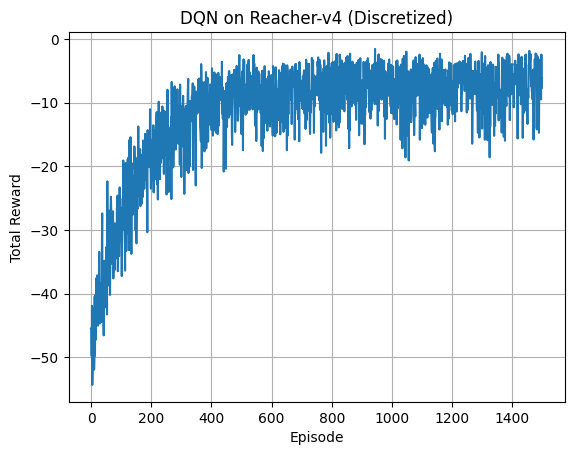

In [ ]:

env = gym.make("Reacher-v4")
state_dim = env.observation_space.shape[0]
buffer = ReplayBuffer() 

agent = DQNAgent(state_dim, action_dim, 0.9011200755283615, 0.00040786284939406864, 0.04312413777249936)


episodes = 1500
epsilon = 1.0
epsilon_min = 0.001
epsilon_decay = 0.9918079894177012
batch_size = 32
rewards_per_episode = []

for ep in range(episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action_idx = agent.select_action(state, epsilon)  
        env_action = discrete_actions[action_idx]  
        next_state, reward, terminated, truncated, _ = env.step(env_action) 
        done = terminated or truncated

        buffer.add(state, action_idx, reward, next_state, done)  
        state = next_state
        total_reward += reward

        if len(buffer) >= batch_size:
            for _ in range(2):  
                batch = buffer.sample(batch_size)
                agent.train_step(batch)
                agent.update_target_network()

    epsilon = max(epsilon * epsilon_decay, epsilon_min)  
    rewards_per_episode.append(total_reward)
    print(f"Episode {ep+1}: Reward = {total_reward:.2f}, Epsilon = {epsilon:.3f}")

env.close()


print(f"Final Episode Reward: {rewards_per_episode[-1]:.2f}")
print(f" Best Reward Achieved: {max(rewards_per_episode):.2f} at Episode {np.argmax(rewards_per_episode) + 1}")
avg_reward = np.mean(rewards_per_episode[-1500:])
print(f"Average Reward : {avg_reward:.2f}")

plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN on Reacher-v4 (Discretized)")
plt.grid(True)
plt.show()


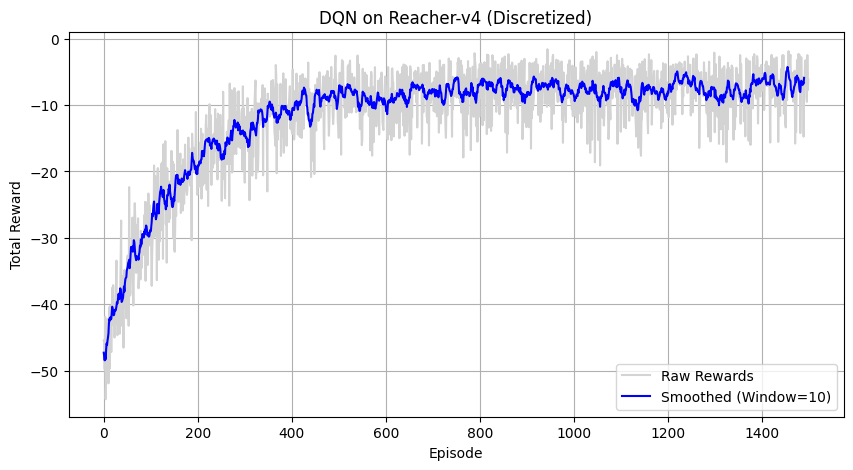

In [ ]:
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_rewards = moving_average(rewards_per_episode, window_size=10)


plt.figure(figsize=(10, 5))
plt.plot(rewards_per_episode, color='lightgray', label='Raw Rewards')
plt.plot(range(len(smoothed_rewards)), smoothed_rewards, color='blue', label='Smoothed (Window=10)')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN on Reacher-v4 (Discretized)")
plt.grid(True)
plt.legend()
plt.show()


#### MOdified from aboveL:

In [ ]:
import imageio

def record_dqn_video(env, agent, filename="dqn_reacher.mp4", gif_filename="dqn_reacher.gif"):
    frames = []
    state, _ = env.reset()
    done = False
    total_reward = 0
    step_count = 0

    while not done:
        frame = env.render()
        frames.append(frame)

        action_idx = agent.select_action(state, epsilon=0.0)  # greedy
        env_action = discrete_actions[action_idx]
        state, reward, terminated, truncated, _ = env.step(env_action)
        total_reward += reward
        step_count += 1
        done = terminated or truncated

    env.close()

  
    imageio.mimsave(filename, frames, fps=30)
    print(f"Saved video to {filename}")

   
    imageio.mimsave(gif_filename, frames, fps=30)
    print(f"Saved gif to {gif_filename}")

  
    print(f"🎯 Greedy Episode Complete: Steps = {step_count}, Total Reward = {total_reward:.2f}")

env = gym.make("Reacher-v4", render_mode="rgb_array")
record_dqn_video(env, agent)



Dropped Escape call with ulEscapeCode : 0x03007703


Saved video to dqn_reacher.mp4
Saved gif to dqn_reacher.gif
🎯 Greedy Episode Complete: Steps = 50, Total Reward = -4.27


In [38]:
from IPython.display import HTML

def display_gif(filename):
    return HTML(f'<img src="{filename}" autoplay loop>')

display_gif("dqn_reacher.gif")


References:
https://gymnasium.farama.org/environments/classic_control/cart_pole/
https://gymnasium.farama.org/environments/box2d/lunar_lander/
"SKM_C301i25052312490.pdf"